# PINN Inverse Solution for 1D Heat Equation
- This notebook demonstrates how to use Physics-Informed Neural Networks (PINNs) to solve the inverse problem for the 1D heat equation.
- We will recover both the solution u(x,t) and the thermal diffusivity coefficient alpha from measurement data.

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Set up system parameters

In [2]:
# Define system parameters
alpha_true = 0.1    # true thermal diffusivity [m^2/s] - this is what we will try to recover
L     = 1           # domain length [m]
T_max = 1           # max time [s]
U_max = 1           # max temperature [°C]


# For the inverse problem, we'll start with a guess that's different from the true value
alpha_guess = 0.05  # initial guess for non-dimensional alpha (50% of true value)

system_params = {'L': L, 'T_max': T_max, 'U_max': U_max}
num_domain_points = 1000
num_boundary_points = 100

## Define initial and boundary conditions

### Configure Initial Conditions

In [3]:
# These functions define the initial temperature distribution and boundary conditions
# create a sinusoidal distribution initial condition
def i_c_sin(x_initial):
    u_initial = torch.sin(torch.pi * x_initial) 
    return u_initial

# create a block heat source initial condition (temperature distribution between 0 and 1)
def i_c_block(x_initial):
    center1 = 0.35
    center2 = 0.8
    width1 = 0.2
    width2 = 0.35
    # Create mask for points inside the block
    mask1 = (x_initial >= (center1 - width1/2)) & (x_initial <= (center1 + width1/2))
    mask2 = (x_initial >= (center2 - width2/2)) & (x_initial <= (center2 + width2/2))
    # Initialize with low temperature
    u_initial = torch.full_like(x_initial, 0)
    # Set high temperature for points inside the block
    u_initial[mask1] = 1
    u_initial[mask2] = 1
    
    return u_initial

def generate_initial_data(num_points, initial_condition = i_c_sin):
    """
    Generate initial condition data
    """
    # Random spatial points for the initial condition
    x_initial = torch.rand(num_points, 1, requires_grad=True)
    # Initial time (t=0)
    t_initial = torch.zeros(num_points, 1, requires_grad=True)
    # Apply the initial condition function
    u_initial = initial_condition(x_initial)
    
    return x_initial, t_initial, u_initial

### Configure Boundry Conditions & Domain Training points

In [4]:
def generate_domain_points(num_points):
    """
    Generate random points inside the domain for PDE residual evaluation
    """
    x_domain = torch.rand(num_points, 1, requires_grad=True)
    t_domain = torch.rand(num_points, 1, requires_grad=True)
    
    return x_domain, t_domain

def generate_boundary_data(num_points, boundary_value=0):
    """
    Generate boundary condition data
    """
    # Left boundary (x=0)
    x_boundary_0 = torch.zeros(num_points, 1, requires_grad=True)
    # Right boundary (x=1)
    x_boundary_1 = torch.ones(num_points, 1, requires_grad=True)
    # Combine both boundaries
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)
    # Random time points for the boundaries
    t_boundary = torch.rand(num_points * 2, 1, requires_grad=True)
    # Boundary values (Dirichlet BC with u=boundary_value at boundaries)
    u_boundary = torch.full_like(x_boundary, boundary_value)
    
    return x_boundary, t_boundary, u_boundary


### Upload measurments data

In [ ]:
# Upload measurments data
file_path = 'Data_sets/sample_results_sinus_1000.csv'
measurments_data = pd.read_csv(file_path)
print('measurments_data.shape:', measurments_data.shape)
measurments_data.head()

### Vizualise training data

In [ ]:
def plot_IC_BC( num_points,
                initial_condition=i_c_sin,
                measurments_data=measurments_data,
                plot_IC_alone=True):
    # Generate data
    
    x_boundary, t_boundary, u_boundary = generate_boundary_data(num_points, boundary_value=0)
    x_initial, t_initial, u_initial = generate_initial_data(num_points, initial_condition)
    x_measure, t_measure, u_measure = measurments_data['x'].values, measurments_data['t'].values, measurments_data['u'].values
    # Convert the tensors to numpy arrays and fix dimensions
    x_init_np , t_init_np , u_init_np = x_initial.detach().numpy(), t_initial.detach().numpy(), u_initial.detach().numpy()
    x_boundary_np , t_boundary_np , u_boundary_np = x_boundary.detach().numpy(), t_boundary.detach().numpy(), u_boundary.detach().numpy()
    x_measure, t_measure, u_measure = x_measure.reshape(-1, 1), t_measure.reshape(-1, 1), u_measure.reshape(-1, 1)
    
    # Unite all x,t,u in one array
    x_np = np.concatenate((x_init_np, x_boundary_np, x_measure))
    t_np = np.concatenate((t_init_np, t_boundary_np, t_measure))
    u_np = np.concatenate((u_init_np, u_boundary_np, u_measure))

    if plot_IC_alone:
        fig = plt.figure(figsize=(8, 4))
        # Scatter plot of u_init_np vs x_init_np
        plt.scatter(x_init_np, u_init_np, c=u_init_np, cmap='coolwarm')
        plt.xlabel('Position x (m)')
        plt.ylabel('Temperature u (°C)')
        plt.title('Initial Condition at time t=0')
        plt.colorbar(label='Temperature')
        plt.show()


    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x_np), np.unique(t_np))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x_np, t_np, np.zeros_like(x_np), c=u_np, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title('Initial Condition and Boundary Condition')
    plt.show()

plot_IC_BC( num_points=num_boundary_points,
                initial_condition=i_c_sin,
                measurments_data=measurments_data,
                plot_IC_alone=False)

## Define PINN model with trainable alpha

In [5]:
class PINN_Inverse(nn.Module):
    """
    PINN for the heat equation with trainable alpha parameter
    """
    def __init__(self, alpha_guess):
        super(PINN_Inverse, self).__init__()
        
        # Trainable alpha parameter
        self.alpha = nn.Parameter(torch.tensor(alpha_guess, dtype=torch.float32))
        
        # Neural network architecture
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Initialize weights and biases using Xavier initialization
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.net(x)
    
    def get_alpha(self):
        """Return the current value of alpha parameter"""
        return self.alpha.item()

## Define PDE residual

In [6]:
def pde_residual(x, t, model):
    """
    Compute the residual of the heat equation PDE
    Using the trainable alpha parameter directly from the model
    """
    # Combine inputs
    inputs = torch.cat([x, t], dim=1)
    # Forward pass through the model
    u = model(inputs)
    
    # Compute derivatives
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True, retain_graph=True,)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True, retain_graph=True)[0]
    du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

    # Heat equation residual using the trainable alpha
    residual = du_dt - (model.alpha * d2u_dx2)
    
    return residual

## Define PINN training loop

In [53]:
def train_inverse_PINN(model, num_iterations,  
                      measurement_data: pd.DataFrame, 
                      initial_condition = i_c_sin,
                      num_points= 1000,
                      loss_weights={'ic': 1, 'bc': 1, 'pde': 1, 'data': 1},
                      print_every=100):
    """
    Train the PINN to recover both the solution and alpha parameter
    """
    # Unpack the measurement data
    x_measure, t_measure, u_measure = measurement_data['x'].values, measurement_data['t'].values, measurement_data['u'].values
    
    x_measure = torch.tensor(x_measure.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    t_measure = torch.tensor(t_measure.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    u_measure = torch.tensor(u_measure.reshape(-1, 1), dtype=torch.float32)
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Create lists to store loss values
    ic_losses = []
    bc_losses = []
    pde_losses = []
    data_losses = []
    total_losses = []
    alpha_values = []
    
    # Unpack the loss weights
    w_ic = loss_weights['ic']
    w_bc = loss_weights['bc']
    w_pde = loss_weights['pde']
    w_data = loss_weights['data']
    
    for iteration in range(num_iterations):
        optimizer.zero_grad()
        
        # Generate training points
        x_domain, t_domain = generate_domain_points(num_points)
        x_boundary, t_boundary, u_boundary = generate_boundary_data(num_points, boundary_value=0)
        x_initial, t_initial, u_initial = generate_initial_data(num_points, initial_condition)

        u_pred_ic = model(torch.cat([x_initial, t_initial], dim=1))
        u_pred_bc = model(torch.cat([x_boundary, t_boundary], dim=1))
        u_pred_data = model(torch.cat([x_measure, t_measure], dim=1))
        residual = pde_residual(x_domain, t_domain, model)
        
        # calculates losses
        # PDE loss
        
        pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual)) * w_pde
        ic_loss = nn.MSELoss()(u_initial, u_pred_ic) * w_ic
        bc_loss = nn.MSELoss()(u_boundary, u_pred_bc) * w_bc
        data_loss = nn.MSELoss()(u_measure, u_pred_data) * w_data   

        
        
        # Calculate total loss with weights
        total_loss = pde_loss + ic_loss + bc_loss + data_loss
        
        # Backpropagation and optimization
        total_loss.backward()
        # update all model parameters including ** model.alpha **
        optimizer.step()
        
        # Store losses
        pde_losses.append(pde_loss.item())
        bc_losses.append(bc_loss.item())
        ic_losses.append(ic_loss.item())
        data_losses.append(data_loss.item())
        total_losses.append(total_loss.item())
        alpha_val= model.get_alpha()
        alpha_values.append(alpha_val)
        
        # Print progress
        if iteration % print_every == 0 or iteration == num_iterations - 1:
            print(f"Iteration {iteration}: "
                  f"total_loss {total_loss.item():.3f}, "
                  f"ic_loss {ic_loss.item():.4f}, "
                  f"bc_loss {bc_loss.item():.4f}, "
                  f"pde_loss {pde_loss.item():.4f}, "
                  f"data_loss {data_loss.item():.4f}, "
                  f"alpha {alpha_val:.4f}")
            
    
    # Create a DataFrame with all the losses
    df = pd.DataFrame({
        'ic_loss': ic_losses, 
        'bc_loss': bc_losses, 
        'pde_loss': pde_losses,
        'data_loss': data_losses,
        'total_loss': total_losses,
        'alpha': alpha_values
    })
    
    return df

### Ploting funcions

In [34]:
def plot_losses_with_alpha(losses_df, alpha_true, log_scale=False):
    """
    Plot training losses and alpha convergence
    """
    plt.figure(figsize=(12, 8))
    
    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(losses_df['total_loss'], label='Total Loss')
    plt.plot(losses_df['pde_loss'], label='PDE Loss')
    plt.plot(losses_df['ic_loss'], label='IC Loss')
    plt.plot(losses_df['bc_loss'], label='BC Loss')
    plt.plot(losses_df['data_loss'], label='Data Loss')
    if log_scale:
        plt.yscale('log')
    plt.title('Losses over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.grid(True)
    
    # Plot alpha convergence
    plt.subplot(2, 1, 2)
    plt.plot(losses_df['alpha'], label='Recovered alpha')
    plt.axhline(y=alpha_true, color='r', linestyle='--', label='True alpha')
    plt.title('Alpha Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_PINN_results(model, num_time_steps=10, measurments_data = None):
    x_plot = []
    t_plot = []
    u_pred = []
    with torch.no_grad():
        x_vals = torch.linspace(0,1,100)
        for t in range(num_time_steps):
            t_val = torch.ones_like(x_vals) * t/num_time_steps 
            input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
            solution = model(input_data)
            x_plot.append(x_vals)
            t_plot.append(t_val)
            u_pred.append(solution)
            
    if measurments_data is not None:
        x_measure, t_measure, u_measure = measurments_data['x'].values, measurments_data['t'].values, measurments_data['u'].values
    # Convert the tensors to numpy arrays and fix dimensions
        x_measure, t_measure, u_measure = x_measure.reshape(-1, 1), t_measure.reshape(-1, 1), u_measure.reshape(-1, 1)

    # Convert to numpy and flatten all arrays
    x_plot = torch.cat(x_plot).numpy()
    t_plot = torch.cat(t_plot).numpy()
    u_pred_np = torch.cat(u_pred).numpy()

    # Plot
    plt.figure(figsize=(8, 7))
    plt.scatter(x_plot, t_plot, c=u_pred_np, cmap='coolwarm')
    if measurments_data is not None:
        plt.scatter(x_measure, t_measure, c=u_measure, cmap='coolwarm')
    plt.clim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Position x (m)')
    plt.ylabel('Time t (s)')
    plt.title(f'PINN Solution with recovered α = {model.get_alpha():.3f}')
    plt.colorbar(label='Temperature')
    plt.show()

## Run the inverse solution
- Train the model with measurments data & Evaluate results

### Sinus IC
- Change the measurmets data to see alpha recovery

Iteration 0: total_loss 0.914, ic_loss 0.5732, bc_loss 0.0119, pde_loss 0.0044, data_loss 0.3245, alpha 0.0040
Iteration 1000: total_loss 0.005, ic_loss 0.0005, bc_loss 0.0006, pde_loss 0.0007, data_loss 0.0037, alpha 0.0922
Iteration 2000: total_loss 0.004, ic_loss 0.0001, bc_loss 0.0001, pde_loss 0.0003, data_loss 0.0033, alpha 0.0969
Iteration 3000: total_loss 0.004, ic_loss 0.0001, bc_loss 0.0001, pde_loss 0.0001, data_loss 0.0033, alpha 0.0984
Iteration 4000: total_loss 0.004, ic_loss 0.0001, bc_loss 0.0001, pde_loss 0.0001, data_loss 0.0033, alpha 0.0987
Iteration 5000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0032, alpha 0.0989
Iteration 6000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0033, alpha 0.0989
Iteration 7000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0033, alpha 0.0988
Iteration 8000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_los

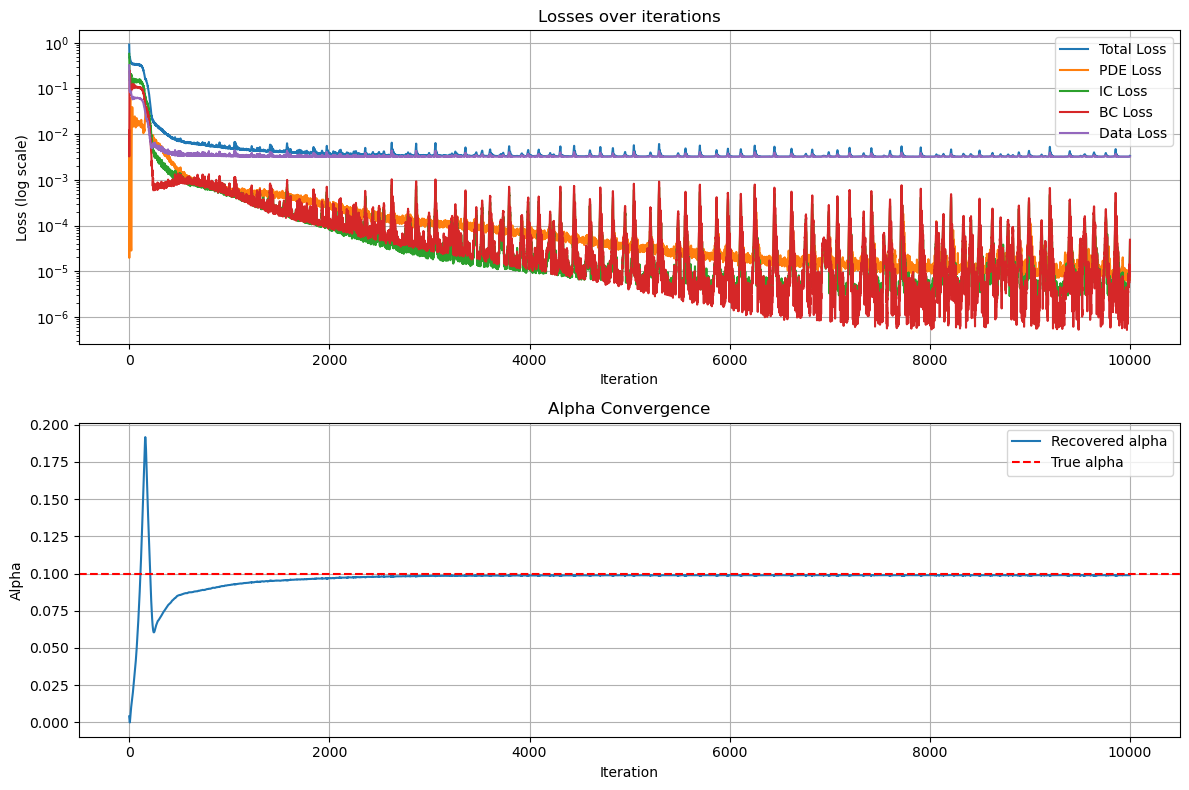

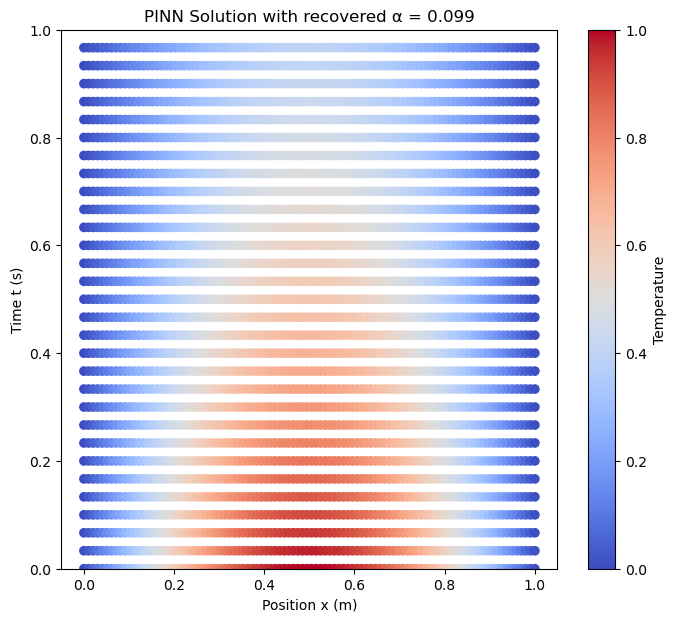

In [61]:
# Upload measurments data
measurments_file = 'sample_results_sinus_1000_alpha_0.1.csv'
measurments_data = pd.read_csv('Data_sets/' + measurments_file)
true_alpha = 0.1

# For the inverse problem, we'll start with a guess that's different from the true value
alpha_guess = 0.005  # initial guess for non-dimensional alpha (50% of true value)

# Initialize the PINN model with our guess for alpha
model_inverse = PINN_Inverse(alpha_guess)

# Train the inverse PINN
losses = train_inverse_PINN (
    model_inverse,
    num_iterations=10000,
    initial_condition = i_c_sin,
    measurement_data = measurments_data,
    loss_weights={'ic': 1, 'bc': 1, 'pde': 1, 'data': 1},
    print_every=1000 )

plot_losses_with_alpha(losses, alpha_true = true_alpha, log_scale=True)
plot_PINN_results (model_inverse, num_time_steps=30)

#### Only PDE and data, no IC BC learning

Iteration 0: total_loss 0.261, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0007, data_loss 0.2600, alpha 0.0060
Iteration 1000: total_loss 0.004, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0002, data_loss 0.0035, alpha 0.0939
Iteration 2000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0033, alpha 0.0966
Iteration 3000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0033, alpha 0.0978
Iteration 4000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0033, alpha 0.0984
Iteration 5000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0033, alpha 0.0986
Iteration 6000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0032, alpha 0.0988
Iteration 7000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_loss 0.0032, alpha 0.0989
Iteration 8000: total_loss 0.003, ic_loss 0.0000, bc_loss 0.0000, pde_loss 0.0000, data_los

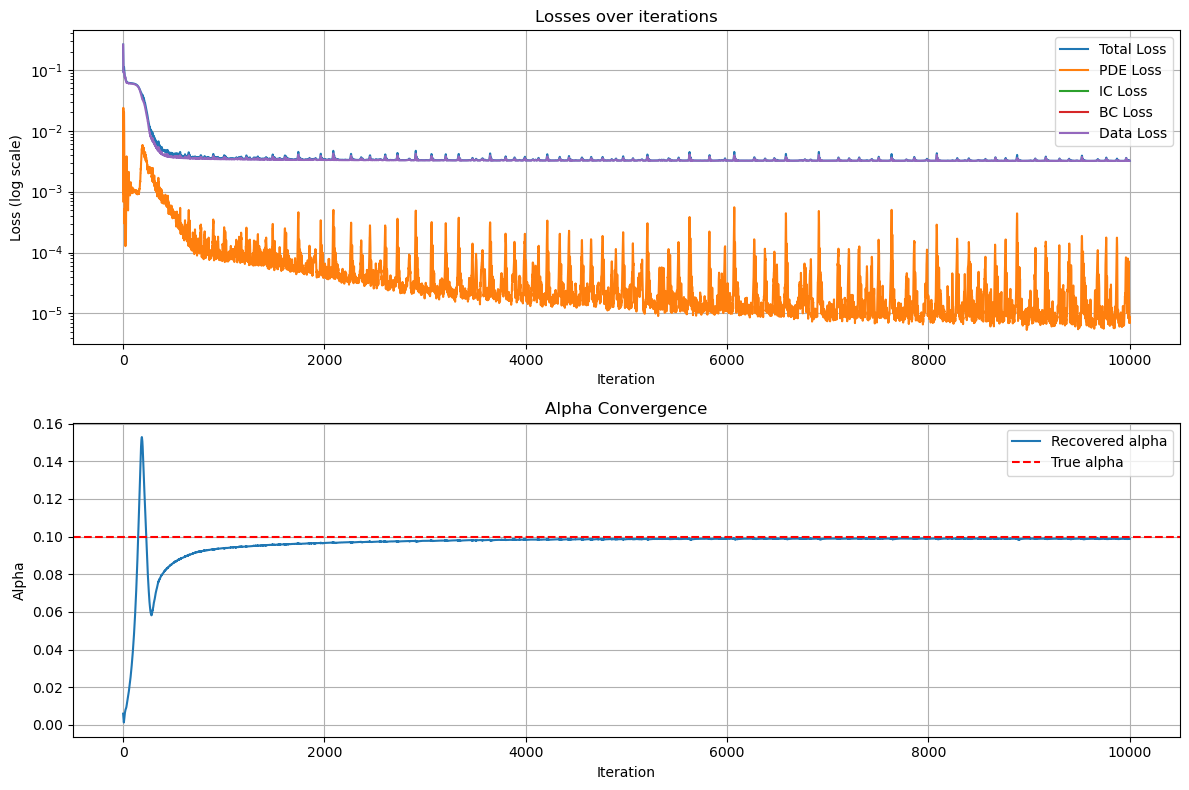

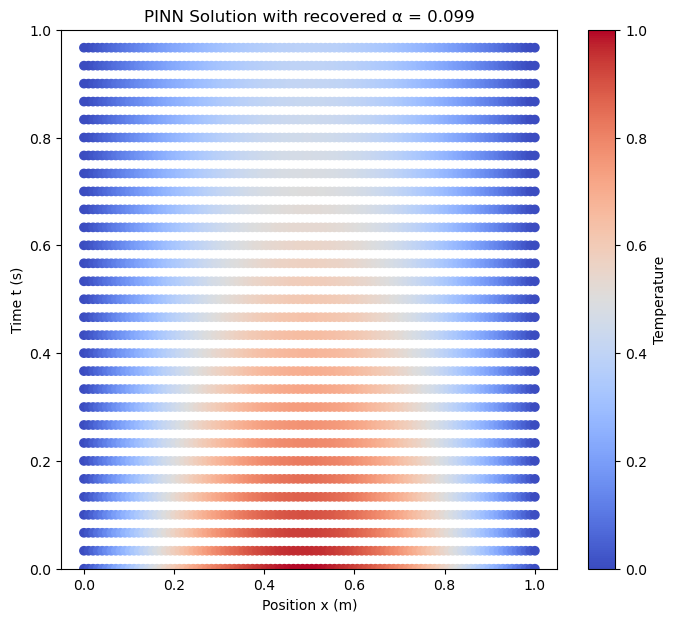

In [64]:
# Upload measurments data
measurments_file = 'sample_results_sinus_1000_alpha_0.1.csv'
measurments_data = pd.read_csv('Data_sets/' + measurments_file)
true_alpha = 0.1

# For the inverse problem, we'll start with a guess that's different from the true value
alpha_guess = 0.005  # initial guess for non-dimensional alpha (50% of true value)

# Initialize the PINN model with our guess for alpha
model_inverse = PINN_Inverse(alpha_guess)

# Train the inverse PINN
losses = train_inverse_PINN (
    model_inverse,
    num_iterations=10000,
    initial_condition = i_c_sin,
    measurement_data = measurments_data,
    loss_weights={'ic': 0, 'bc': 0, 'pde': 1, 'data': 1},
    print_every=1000 )

plot_losses_with_alpha(losses, alpha_true = true_alpha, log_scale=True)
plot_PINN_results (model_inverse, num_time_steps=30)

### Block IC
- Adjust the loss weights to improve convergence

Iteration 0: total_loss 2.608, ic_loss 1.2641, bc_loss 0.3136, pde_loss 0.0320, data_loss 0.9981, alpha 0.0040
Iteration 1000: total_loss 0.258, ic_loss 0.2007, bc_loss 0.0205, pde_loss 0.0026, data_loss 0.0338, alpha 0.0523
Iteration 2000: total_loss 0.077, ic_loss 0.0526, bc_loss 0.0028, pde_loss 0.0050, data_loss 0.0161, alpha 0.0053
Iteration 3000: total_loss 0.048, ic_loss 0.0376, bc_loss 0.0006, pde_loss 0.0031, data_loss 0.0065, alpha 0.0119
Iteration 4000: total_loss 0.041, ic_loss 0.0333, bc_loss 0.0007, pde_loss 0.0020, data_loss 0.0052, alpha 0.0148
Iteration 5000: total_loss 0.042, ic_loss 0.0341, bc_loss 0.0002, pde_loss 0.0024, data_loss 0.0051, alpha 0.0161
Iteration 6000: total_loss 0.038, ic_loss 0.0321, bc_loss 0.0002, pde_loss 0.0013, data_loss 0.0048, alpha 0.0170
Iteration 7000: total_loss 0.039, ic_loss 0.0327, bc_loss 0.0003, pde_loss 0.0012, data_loss 0.0046, alpha 0.0172
Iteration 8000: total_loss 0.040, ic_loss 0.0335, bc_loss 0.0002, pde_loss 0.0018, data_los

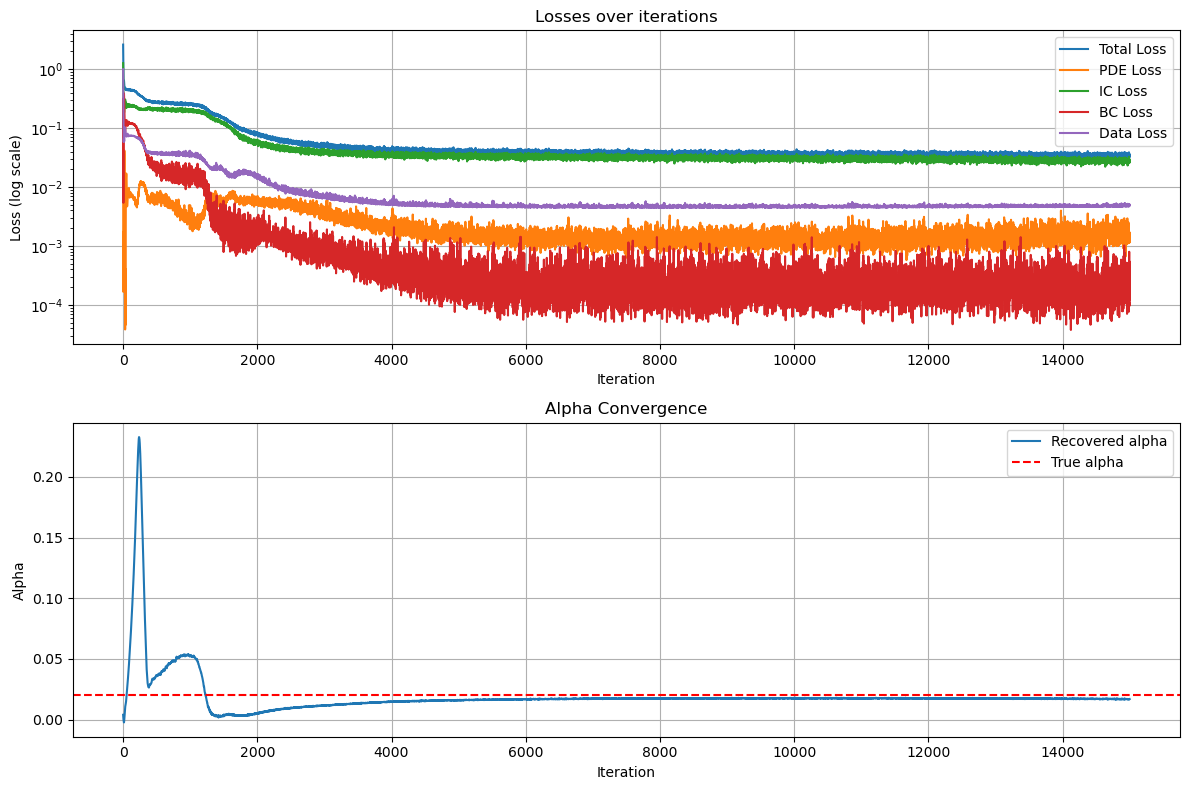

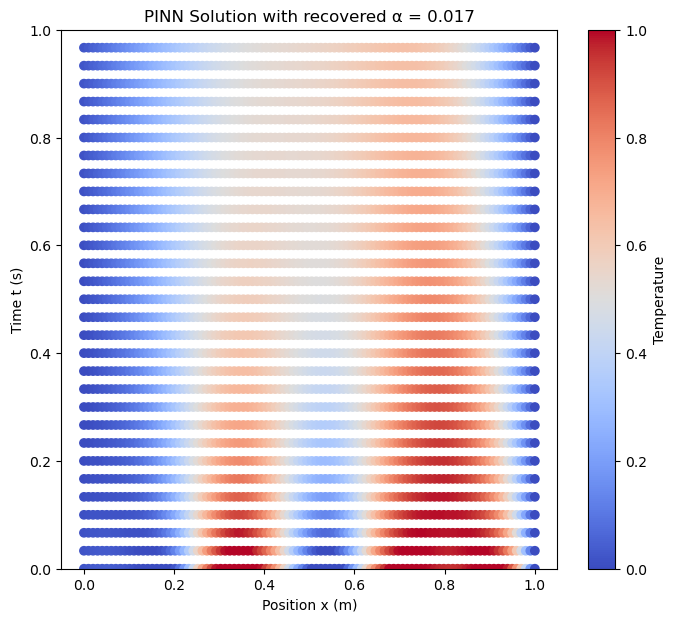

In [69]:
# Upload measurments data
measurments_file = 'sample_data_blockIC_1000_alpha_0.02.csv'
measurments_data = pd.read_csv('Data_sets/' + measurments_file)
true_alpha = 0.02

# For the inverse problem, we'll start with a guess that's different from the true value
alpha_guess = 0.005  # initial guess for non-dimensional alpha (50% of true value)

# Initialize the PINN model with our guess for alpha
model_inverse = PINN_Inverse(alpha_guess)

# Train the inverse PINN
losses = train_inverse_PINN (
    model_inverse,
    num_iterations=15000,
    initial_condition = i_c_block,
    measurement_data = measurments_data,
    loss_weights={'ic': 1, 'bc': 1, 'pde': 1, 'data': 1}, 
    print_every=1000 )

plot_losses_with_alpha(losses, alpha_true = true_alpha, log_scale=True)
plot_PINN_results (model_inverse, num_time_steps=30)

#### With Adjusted Weights

Iteration 0: total_loss 15.610, ic_loss 0.5584, bc_loss 0.0003, pde_loss 0.0581, data_loss 14.9936, alpha 0.0060
Iteration 1000: total_loss 1.945, ic_loss 0.1960, bc_loss 0.0571, pde_loss 0.0220, data_loss 1.6698, alpha 0.0369
Iteration 2000: total_loss 1.591, ic_loss 0.1803, bc_loss 0.0248, pde_loss 0.0521, data_loss 1.3342, alpha 0.0094
Iteration 3000: total_loss 0.681, ic_loss 0.0989, bc_loss 0.0037, pde_loss 0.0779, data_loss 0.5006, alpha 0.0083
Iteration 4000: total_loss 0.460, ic_loss 0.0830, bc_loss 0.0039, pde_loss 0.0356, data_loss 0.3375, alpha 0.0132
Iteration 5000: total_loss 0.363, ic_loss 0.0659, bc_loss 0.0036, pde_loss 0.0240, data_loss 0.2698, alpha 0.0161
Iteration 6000: total_loss 0.325, ic_loss 0.0553, bc_loss 0.0037, pde_loss 0.0188, data_loss 0.2472, alpha 0.0174
Iteration 7000: total_loss 0.328, ic_loss 0.0513, bc_loss 0.0045, pde_loss 0.0248, data_loss 0.2472, alpha 0.0182
Iteration 8000: total_loss 0.294, ic_loss 0.0505, bc_loss 0.0039, pde_loss 0.0076, data_l

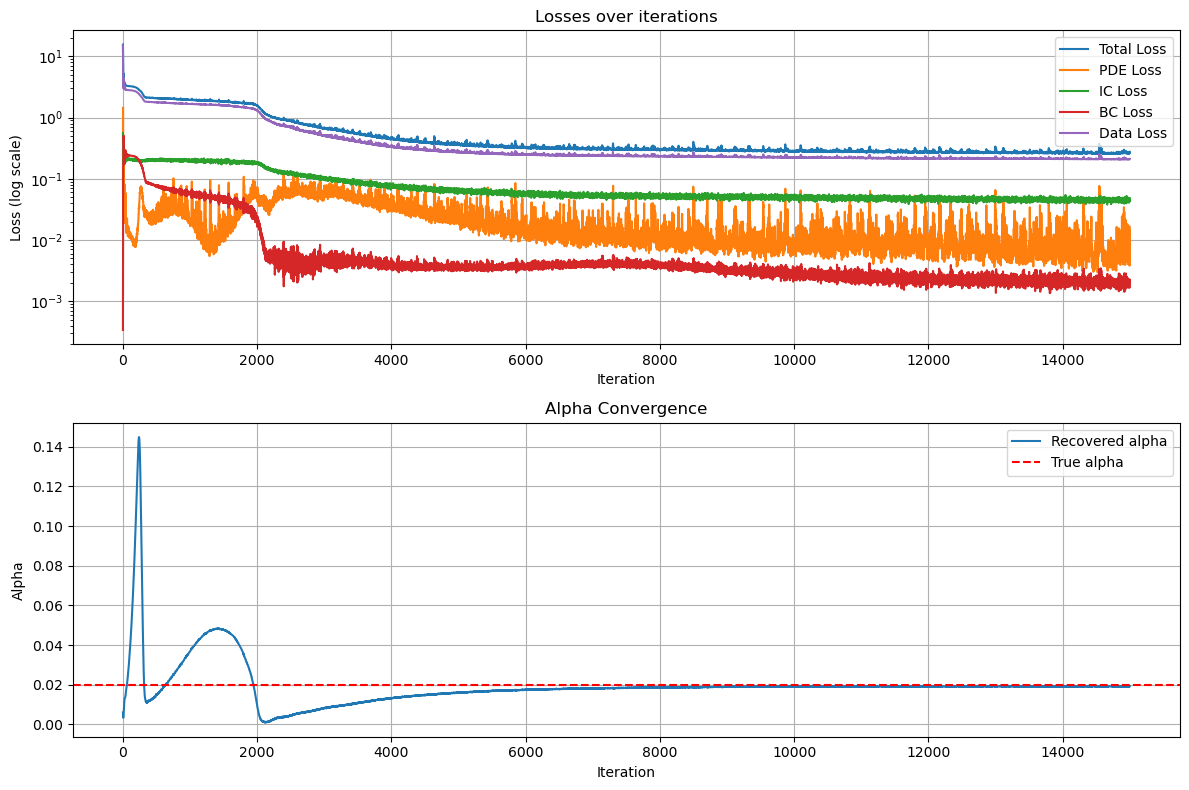

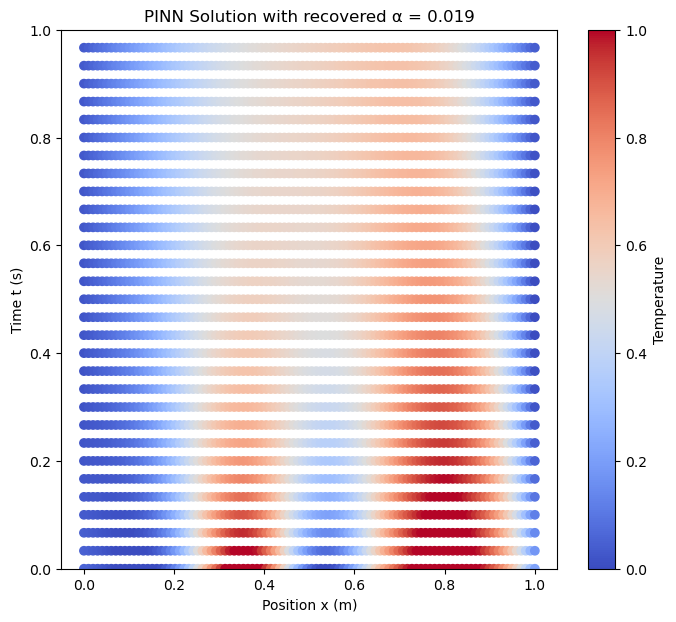

In [68]:
# Upload measurments data
measurments_file = 'sample_data_blockIC_1000_alpha_0.02.csv'
measurments_data = pd.read_csv('Data_sets/' + measurments_file)
true_alpha = 0.02

# For the inverse problem, we'll start with a guess that's different from the true value
alpha_guess = 0.005  # initial guess for non-dimensional alpha (50% of true value)

# Initialize the PINN model with our guess for alpha
model_inverse = PINN_Inverse(alpha_guess)

# Train the inverse PINN
losses = train_inverse_PINN (
    model_inverse,
    num_iterations=15000,
    initial_condition = i_c_block,
    measurement_data = measurments_data,
    loss_weights={'ic': 1, 'bc': 1, 'pde': 100, 'data': 50},
    print_every=1000 )

plot_losses_with_alpha(losses, alpha_true = true_alpha, log_scale=True)
plot_PINN_results (model_inverse, num_time_steps=30)